In [25]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from gensim.models import Word2Vec, KeyedVectors, Doc2Vec
import string
import pickle

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE

matplotlib.style.use('ggplot')

In [5]:
# import google's word2vec located: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
w2v_model = KeyedVectors.load_word2vec_format('../../../Downloads/GoogleNews-vectors-negative300.bin', binary=True)  

In [6]:
ticker = 'TSLA'

In [8]:
df = pd.read_csv(f'../data/{ticker}_articles.csv')

In [9]:
def clean2vect(articles):
    new_list = []
    for a in articles:
        new_list.append(a.replace(',','').translate(string.punctuation))

    clean_articles = [word.split() for word in new_list]

    vects = []

    for a in clean_articles:
        vector = []
        for word in a:
            try:
                vector.append(w2v_model[word])
            except:
                continue
        try: 
            vects.append(sum(vector)/len(vector))
        except:
            vects.append(1)
    return vects

#### *NOTE Do we need to scale vectors?

In [10]:
df['article_vect'] = clean2vect(df['article'])
df['name_vect'] = clean2vect(df['name'])

# df['comments'] = clean2vect(df['comments'])
# df['comments_qty'] = [int(i.split(" ")[0]) for i in df['comments_qty']]

### Set Article DataFrame to Date Index to match with stock info

In [11]:
def art_date(df):
    dates = []
    for i in df.date:
        if "Today" in i:
            dates.append('2020-' + str(i.replace(i, date.today().strftime("%m-%d"))))
        elif 'Sat, Feb. 29' in i:
            dates.append('2020-03-01')
        elif "Yesterday" in i:
            dates.append('2020-' + str(i.replace(i, (date.today() - timedelta(days = 1)).strftime("%m-%d"))))
        else:
            try: 
                dates.append('2020-' + str(datetime.strptime(i,'%a, %b. %d').strftime('%m-%d')))
            except:
                try:
                    dates.append('2020-' + str(datetime.strptime(i,'%a, %b %d').strftime('%m-%d')))
                except:
                    dates.append(str(datetime.strptime(i,'%a, %b. %d, %Y').strftime('%Y-%m-%d')))
#         set dataframe to new dates columns as index
    df.date = dates
    df.date = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    return df

In [12]:
df = art_date(df)

## KMEANS

In [26]:

X = df['article_vect']

art_kclusterer = KMeansClusterer(num_means=2, normalise=False, distance=nltk.cluster.util.euclidean_distance, 
                             repeats=40,avoid_empty_clusters=True)
df['art_clusters'] = art_kclusterer.cluster(X, assign_clusters=True)

X2 = df['name_vect']
name_kclusterer = KMeansClusterer(num_means=2, normalise=True, distance=nltk.cluster.util.euclidean_distance, 
                             repeats=40,avoid_empty_clusters=True)
df['name_clusters'] = name_kclusterer.cluster(X2, assign_clusters=True)

article_silhouette = metrics.silhouette_score([a for a in df['article_vect']], df['art_clusters'], metric='euclidean')
name_silhouette = metrics.silhouette_score([a for a in df['name_vect']], df['name_clusters'], metric='euclidean')

print(article_silhouette)
print(name_silhouette)

0.120440915
0.05910767


In [335]:
# pickle the clusterer files
with open('./pickle_jar/art_clusterer_pkl', 'wb') as acp:
    pickle.dump(art_kclusterer, acp)
with open('./pickle_jar/name_clusterer_pkl', 'wb') as ncp:
    pickle.dump(name_kclusterer, ncp)


In [27]:
# cell to find the elbow for KMEANS K value for the name
X2_elbow = [a for a in df['name_vect']]

distortions2 = [] 
inertias2 = [] 
mapping1b = {} 
mapping2b = {} 
K2 = range(1,10) 
  
for k in K2: 
    #Building and fitting the model 
    kmeanModel2 = KMeans(n_clusters=k).fit(X2_elbow) 
    kmeanModel2.fit(X2_elbow)     
      
    distortions2.append(sum(np.min(cdist(X2_elbow, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / len(X2_elbow))
    inertias2.append(kmeanModel.inertia_) 
  
    mapping1b[k] = sum(np.min(cdist(X2_elbow, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / len(X2_elbow)
    mapping2b[k] = kmeanModel.inertia_ 
for key,val in mapping1b.items(): 
    print(str(key)+' : '+str(val)) 

NameError: name 'kmeanModel' is not defined

In [28]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

NameError: name 'K' is not defined

In [29]:
X = [a for a in df['article_vect']]

kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
# print ("Centroids data")
# print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1
 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1
 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0
 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1
 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-40.346328321098554
Silhouette_score: 
0.12639076


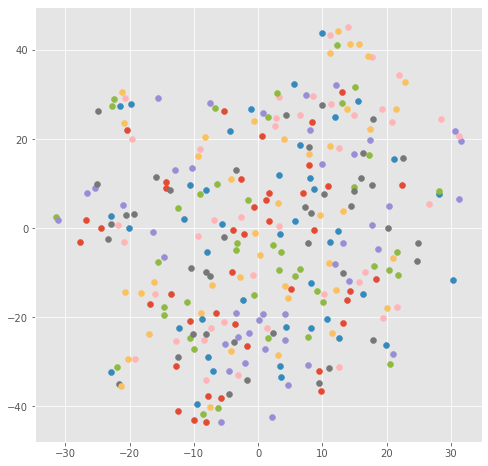

In [36]:
# from https://towardsdatascience.com/understanding-word2vec-embedding-in-practice-3e9b8985953

def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for ind, link in df.iterrows():
        tokens.append(link[4])
        labels.append(ind)
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])

    plt.show()
   
tsne_plot(w2v_model)

In [336]:
# save article dataframe to a pickle file
with open('./pickle_jar/articlePickle', 'wb') as fp:
    pickle.dump(df, fp)


## DOC2VEC